In [ ]:
!pip install rdkit & > /dev/null

In [1]:
import torch
import random
import typing
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from rdkit import Chem
from rdkit import DataStructs
from torch.utils.data import Dataset
from sklearn.metrics import accuracy_score
from rdkit.Chem import AllChem, Descriptors
from sklearn.preprocessing import FunctionTransformer

warnings.filterwarnings('ignore')

In [2]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [3]:
data = pd.read_excel('data/All-1614.xlsx')
data.head()

,Title,"IC50, mmg/ml","CC50-MDCK, mmg/ml",SI,Molecular weight,Hydrogen bond acceptors,Hydrogen bond donors,Polar SA,SMILES,Pictures
0,1007-Ya-213,2.7,500.0,185.185185,195.307,2,1,32.59,OCC\N=C(\[C@]12C)C[C@@H](C1(C)C)CC2,50.0
1,1007-Ya-213,0.7,447.0,638.571429,195.307,2,1,32.59,OCC\N=C(\[C@]12C)C[C@@H](C1(C)C)CC2,51.0
2,1008-Ya-187,9.9,144.0,14.545455,250.431,1,0,15.60,CCN(CC)CC\N=C(\[C@@]12C)C[C@H](C1(C)C)CC2,52.0
3,1009-As-106,8.3,500.0,60.240964,222.377,1,0,15.60,CN(C)CC\N=C(\[C@@]12C)C[C@H](C1(C)C)CC2,53.0
4,1010-Ya-208,39.4,143.0,3.629442,239.361,2,0,29.54,CN(C)CC(=O)O[C@H]1C[C@H](CC2)C(C)(C)[C@@]12C,54.0


In [4]:
data.rename(
    columns={'IC50, mmg/ml': 'IC50', 'CC50-MDCK, mmg/ml': 'CC50'},
    inplace=True
)

In [5]:
def mol_dsc_calc(mols):
    return pd.DataFrame({k: f(Chem.MolFromSmiles(m)) for k, f in descriptors.items()} for m in mols)


# список конституционных и физико-химических дескрипторов из библиотеки RDKit
descriptors = {
    'HeavyAtomCount': Descriptors.HeavyAtomCount,
    'NHOHCount': Descriptors.NHOHCount,
    'NOCount': Descriptors.NOCount,
    'NumHAcceptors': Descriptors.NumHAcceptors,
    'NumHDonors': Descriptors.NumHDonors,
    'NumHeteroatoms': Descriptors.NumHeteroatoms,
    'NumRotatableBonds': Descriptors.NumRotatableBonds,
    'NumValenceElectrons': Descriptors.NumValenceElectrons,
    'NumAromaticRings': Descriptors.NumAromaticRings,
    'NumAliphaticHeterocycles': Descriptors.NumAliphaticHeterocycles,
    'RingCount': Descriptors.RingCount,
    'MW': Descriptors.MolWt,
    'LogP': Descriptors.MolLogP,
    'MR': Descriptors.MolMR,
    'TPSA': Descriptors.TPSA
}

# sklearn трансформер для использования в конвейерном моделировании
descriptors_transformer = FunctionTransformer(mol_dsc_calc)

In [6]:
def rdkit_fp(smiles_column: pd.Series, radius=3, nBits=2048, useChirality=False):
    # morganFP_rdkit
    def desc_gen(mol):
        mol = Chem.MolFromSmiles(mol)
        bit_vec = np.zeros((1,), np.int16)
        DataStructs.ConvertToNumpyArray(
            AllChem.GetMorganFingerprintAsBitVect(mol, radius=radius, nBits=nBits, useChirality=useChirality), bit_vec)
        return bit_vec

    return pd.DataFrame.from_records(smiles_column.apply(func=desc_gen), columns=[f'bit_id_{i}' for i in range(nBits)])


def rdkit_2d(smiles_column: pd.Series):
    # 2d_rdkit
    descriptors = {i[0]: i[1] for i in Descriptors._descList}
    return pd.DataFrame({k: f(Chem.MolFromSmiles(m)) for k, f in descriptors.items()} for m in smiles_column)

In [7]:
from dataclasses import dataclass


@dataclass
class SMILESDescriptor:
    descriptor: typing.Callable
    title: typing.Optional[str] = None

In [8]:
class SMILESMolDataset(Dataset):
    def __init__(
            self,
            *,
            data: pd.DataFrame,
            x_columns: typing.Optional[typing.List[str]] = None,
            delete_x_columns: typing.Optional[typing.List[str]] = None,
            y_columns: typing.List[str],
            x_transform: typing.Optional[typing.Callable] = None,
            y_transform: typing.Optional[typing.Callable] = None,
            smiles_descriptors: typing.Optional[typing.Iterable[SMILESDescriptor]] = None
    ):
        self.data = data
        self.x_columns = x_columns
        self.delete_x_columns = delete_x_columns
        self.y_columns = y_columns
        self.x_transform = x_transform
        self.y_transform = y_transform
        self.smiles_descriptors = smiles_descriptors

        self._descript_smiles()
        self._separate_data()

    # применяем дескрипторы
    def _descript_smiles(self):
        if self.smiles_descriptors:
            for d in self.smiles_descriptors:
                d_data = d.descriptor(self.data['SMILES'])
                self.data = self.data.join(d_data, lsuffix=d.title or '')

    # разделяем данные на x и y
    def _separate_data(self):
        x = self.data

        if self.x_columns:
            x = x[self.x_columns]

        if not self.delete_x_columns:
            self.delete_x_columns = []
        self.delete_x_columns += self.y_columns
        x = x.drop(columns=self.delete_x_columns)

        if self.x_transform:
            for column in self.x_columns:
                x[column] = x[column].apply(self.x_transform)
        self.x = x

        y = self.data[self.y_columns]
        if self.y_transform:
            for column in self.y_columns:
                y[column] = y[column].apply(self.y_transform)
        self.y = y

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        return self.x.loc[idx].values, self.y.loc[idx].values

In [9]:
train_data = data.sample(frac=0.8, random_state=seed)
test_data = data.drop(train_data.index)

train_data = train_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)

<Axes: xlabel='CC50', ylabel='Count'>

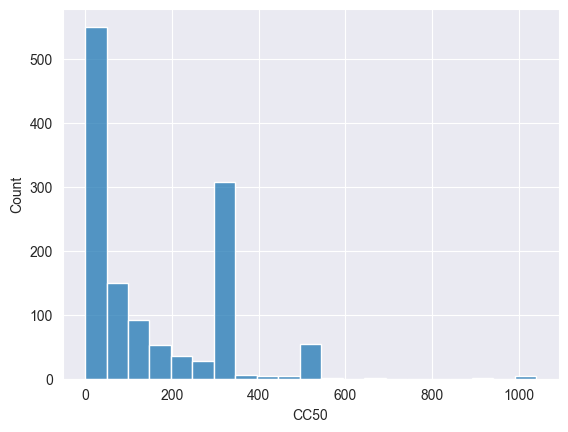

In [10]:
sns.histplot(train_data['CC50'])

In [11]:
cc50_median = train_data['CC50'].median()
cc50_median

75.3785

<Axes: xlabel='IC50', ylabel='Count'>

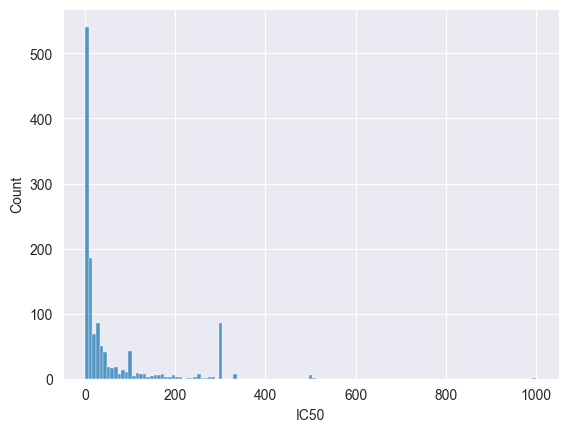

In [12]:
sns.histplot(train_data['IC50'])

In [13]:
ic50_median = train_data['IC50'].median()
ic50_median

11.350000000000001

In [17]:
dataset_args = {
    'x_columns': None,
    'delete_x_columns': ['Title', 'SMILES', 'IC50', 'SI'],
    'y_columns': ['CC50'],
    'x_transform': None,
    'y_transform': lambda y: int(y >= cc50_median),
    'smiles_descriptors': [
        SMILESDescriptor(descriptors_transformer.transform),
        SMILESDescriptor(rdkit_fp, 'rdkit_fp'),
        SMILESDescriptor(rdkit_2d, 'rdkit_2d')
    ]
}

train_dataset = SMILESMolDataset(data=train_data, **dataset_args)
test_dataset = SMILESMolDataset(data=test_data, **dataset_args)

In [18]:
train_dataset[1]

(array([167.253,   2.   ,   1.   , ...,   0.   ,   0.   ,   0.   ]),
 array([1], dtype=int64))

<Axes: ylabel='Count'>

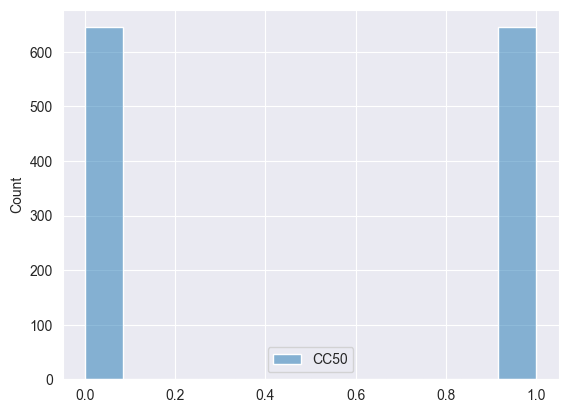

In [19]:
sns.histplot(train_dataset.y)

In [20]:
from sklearn.model_selection import GridSearchCV


class TrainingModel:
    def __init__(
            self,
            *,
            model: typing.Any,
            fit_method: str = 'fit',
            predict_method: str = 'predict',
            **kwargs
    ):
        self.model = model(**kwargs)  # Экземпляр модели с начальными параметрами
        self._fit_method = fit_method
        self._predict_method = predict_method

    def fit(self, x_train: pd.DataFrame, y_train: pd.DataFrame, **kwargs):
        getattr(self.model, self._fit_method)(x_train, y_train, **kwargs)

    def predict(self, x_test: pd.DataFrame, **kwargs) -> typing.Union[np.ndarray]:
        return getattr(self.model, self._predict_method)(x_test, **kwargs)

    def grid_search(
            self,
            *,
            param_grid: typing.Dict[str, typing.List[typing.Any]],
            x_train: pd.DataFrame,
            y_train: pd.DataFrame,
            **kwargs
    ):
        grid_search = GridSearchCV(
            estimator=self.model,
            param_grid=param_grid,
            **kwargs
        )

        grid_search.fit(x_train, y_train)

        self.model = grid_search.best_estimator_

        print('Лучшие параметры:', grid_search.best_params_)
        print('Лучшая оценка:', grid_search.best_score_)

        return grid_search


In [ ]:
!pip install catboost & > /dev/null

In [33]:
from catboost import CatBoostClassifier

training_model = TrainingModel(
    model=CatBoostClassifier,
    iterations=1000,
    depth=8,
    l2_leaf_reg=1,
    verbose=0
)

In [26]:
param_grid = {
    'iterations': [300, 500, 1000],
    'learning_rate': [0.01, 0.05, 0.1, None],
    'depth': [4, 6, 8, None],
    'l2_leaf_reg': [1, 3, 5, None],
}
training_model.grid_search(
    param_grid=param_grid,
    x_train=train_dataset.x,
    y_train=train_dataset.y,
    cv=5,
    scoring='accuracy',
    verbose=2
)

Fitting 5 folds for each of 192 candidates, totalling 960 fits
[CV] END depth=4, iterations=300, l2_leaf_reg=1, learning_rate=0.01; total time=   1.4s
[CV] END depth=4, iterations=300, l2_leaf_reg=1, learning_rate=0.01; total time=   1.6s
[CV] END depth=4, iterations=300, l2_leaf_reg=1, learning_rate=0.01; total time=   1.8s
[CV] END depth=4, iterations=300, l2_leaf_reg=1, learning_rate=0.01; total time=   1.6s
[CV] END depth=4, iterations=300, l2_leaf_reg=1, learning_rate=0.01; total time=   1.5s
[CV] END depth=4, iterations=300, l2_leaf_reg=1, learning_rate=0.05; total time=   1.8s
[CV] END depth=4, iterations=300, l2_leaf_reg=1, learning_rate=0.05; total time=   1.8s
[CV] END depth=4, iterations=300, l2_leaf_reg=1, learning_rate=0.05; total time=   1.6s
[CV] END depth=4, iterations=300, l2_leaf_reg=1, learning_rate=0.05; total time=   1.6s
[CV] END depth=4, iterations=300, l2_leaf_reg=1, learning_rate=0.05; total time=   1.6s
[CV] END depth=4, iterations=300, l2_leaf_reg=1, learning

GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostClassifier object at 0x0000029D8E4E3590>,
             param_grid={'depth': [4, 6, 8, None],
                         'iterations': [300, 500, 1000],
                         'l2_leaf_reg': [1, 3, 5, None],
                         'learning_rate': [0.01, 0.05, 0.1, None]},
             scoring='accuracy', verbose=2)

Лучшие параметры:
для IC50 {'depth': 8, 'iterations': 500, 'l2_leaf_reg': 3, 'learning_rate': 0.01}
для CC50 {'depth': 8, 'iterations': 1000, 'l2_leaf_reg': 1, 'learning_rate': 0.05}

In [34]:
training_model.fit(train_dataset.x, train_dataset.y)

In [35]:
y_pred = training_model.predict(test_dataset.x)

In [36]:
accuracy_score(y_pred, test_dataset.y)

0.8142414860681114

| Accuracy table |        |        |
|----------------|--------|--------|
|                | CC50   | IC50   |
| CatBoost       |        |        |
| default        | 0.7988 | 0.7788 |
| GridSearchCV   | 0.8142 | 0.7801 |